# 05 - CNN Baseline

In questo notebook addestriamo un **modello CNN baseline** per la classificazione delle immagini di rifiuti.

**Obiettivi:**
- usare la pipeline `tf.data` definita in `src`
- addestrare una CNN semplice come baseline
- valutare le prestazioni su validation e test set

Questo modello rappresenta il primo vero modello “image-based” del progetto,
da confrontare con la baseline lineare.

#### 0) Import librerie e moduli progetto e setup path

Effettuo le seguenti operazioni a partire da:
- `src/garbagecls/db.py`
- `src/garbagecls/paths.py`
- `src/garbagecls/dataset.py`

In [11]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name.lower() == "notebooks" else Path.cwd()
sys.path.append(str(ROOT / "src"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from garbagecls.db import load_env, read_images_df, split_dfs
from garbagecls.dataset import build_label_maps, make_dataset


#### 1) Caricamento dati da DB e creazione dei 3 dataset

In [ ]:
load_env()

df = read_images_df(source="raw_flat")
df_train, df_val, df_test = split_dfs(df) # df_test_our

label2id, id2label = build_label_maps(df["label"].unique())
num_classes = len(label2id)

for d in (df_train, df_val, df_test):
    d["label_id"] = d["label"].map(label2id).astype("int32")

IMG_SIZE = (384, 512)
BATCH_SIZE = 32
SEED = 42

train_ds = make_dataset(
    df_train, training=True,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=True
)

val_ds = make_dataset(
    df_val, training=False,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=False
)

test_ds = make_dataset(
    df_test, training=False,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    augment=False
)

#test_ds_our

num_classes

print(train_ds.element_spec)


c:\Users\simon\Documents\VSC\Progetto-Data-Science\src\garbagecls\db.py:77: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(base_query, conn, params=params if params else None)


(TensorSpec(shape=(None, 384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


#### 2) Definizione CNN baseline

In [14]:
model = keras.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax"),
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 382, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 191, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 189, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 94, 126, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 92, 124, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 46, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 365056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    46,727,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,821,318 (178.61 MB)

 Trainable params: 46,821,318 (178.61 MB)

 Non-trainable params: 0 (0.00 B)

#### 3) Compilazione e training

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), # Adam optimizer with a learning rate of 0.001 
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.3184 - loss: 2.2976 - val_accuracy: 0.4222 - val_loss: 1.3598
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.4712 - loss: 1.3052 - val_accuracy: 0.4697 - val_loss: 1.3447
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.5181 - loss: 1.2142 - val_accuracy: 0.5462 - val_loss: 1.1638
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.5633 - loss: 1.1025 - val_accuracy: 0.5620 - val_loss: 1.2306
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.6046 - loss: 1.0626 - val_accuracy: 0.5620 - val_loss: 1.1492
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.6176 - loss: 0.9889 - val_accuracy: 0.5726 - val_loss: 1.1784
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.6527 - loss: 0.9427 - val_accuracy: 0.5541 - val_loss: 1.1967
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.6646 - loss: 0.9057 - val_accuracy: 0.6095 - v

#### Salvataggio modello addestrato

In [16]:
from pathlib import Path
import datetime

MODELS_DIR = ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
model_path = MODELS_DIR / f"cnn_baseline_{stamp}.keras"

model.save(model_path)
print("Saved to:", model_path)


Saved to: c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_baseline_20260203-1531.keras


#### Caricamento modello

In [ ]:
from tensorflow import keras

model = keras.models.load_model(model_path)
model.summary()

print("Model loaded from:", model_path)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 382, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 191, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 189, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 94, 126, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 92, 124, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 46, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 365056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    46,727,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,463,956 (535.83 MB)

 Trainable params: 46,821,318 (178.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 93,642,638 (357.22 MB)

Model loaded from: c:\Users\simon\Documents\VSC\Progetto-Data-Science\models\cnn_baseline_20260203-1531.keras


#### 4) Valutazione sul test set

In [ ]:
test_loss, test_acc = model.evaluate(test_ds) #test_ds_our in sostituzione quando verrà aggiunto
print(f"Test accuracy: {test_acc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - accuracy: 0.5921 - loss: 1.2609
Test accuracy: 0.5921


#### 5) Curve di training

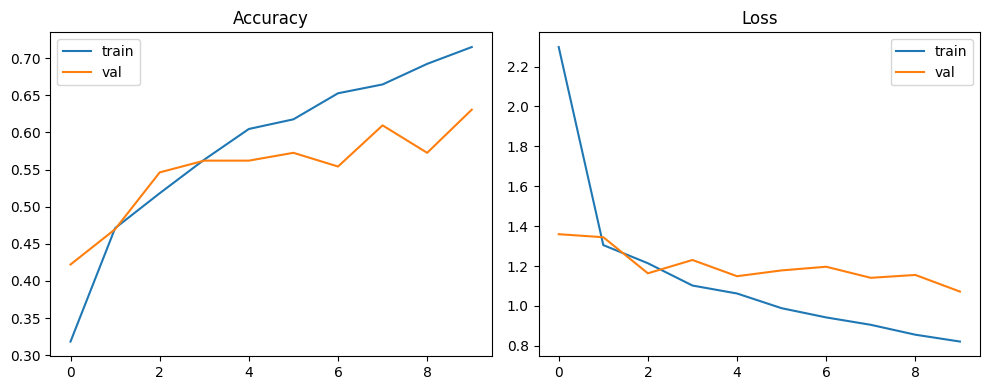

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()


**Train accuracy** cresce in modo regolare, mentre **validation accuracy** si stabilizza presto intorno a 0.60. Quindi il modello impara ma tendo ad un leggero overfitting, ma non collassa la curva val, quindi modello stabile.

**Train loss** descresce costantemente, mentre **validation loss** non lo fa in modo così marcato. Potremmo introdurre un early stopping

#### 6) Classification Report con Confusion Matrix

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 1) predizioni
y_true = []
y_pred = []

for x_batch, y_batch in test_ds: #test_ds_our in sostituzione quando verrà aggiunto
    probs = model.predict(x_batch, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(preds.tolist())

# 2) confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Classification report:")
target_names = [id2label[i] for i in range(len(id2label))]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))


Classification report:
              precision    recall  f1-score   support

   cardboard     0.6714    0.7833    0.7231        60
       glass     0.7619    0.4211    0.5424        76
       metal     0.5333    0.3871    0.4486        62
       paper     0.5154    0.7528    0.6119        89
     plastic     0.6087    0.5753    0.5915        73
       trash     0.5417    0.6500    0.5909        20

    accuracy                         0.5921       380
   macro avg     0.6054    0.5949    0.5847       380
weighted avg     0.6116    0.5921    0.5839       380



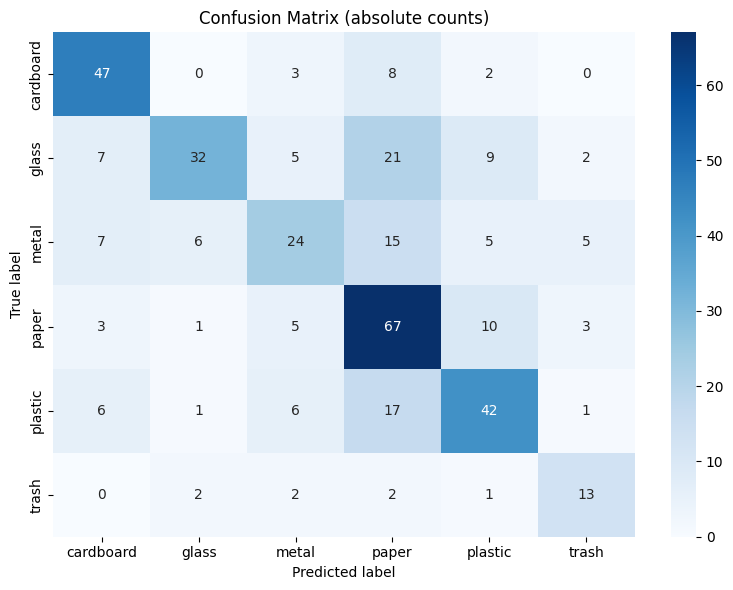

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (absolute counts)")
plt.tight_layout()
plt.show()


La **riga** di fatto ci mostra la `recall`, ovvero tra tutte quelle davvero della classe X, quante ne becco.

La **colonna** invece ci indica la `precision`, ovvero di quelle che ho predetto X, quante davvero lo sono.

**ESEMPIO:** Per *paper* ho una buona recall (0.75), ma una precision inferiore (0.52)


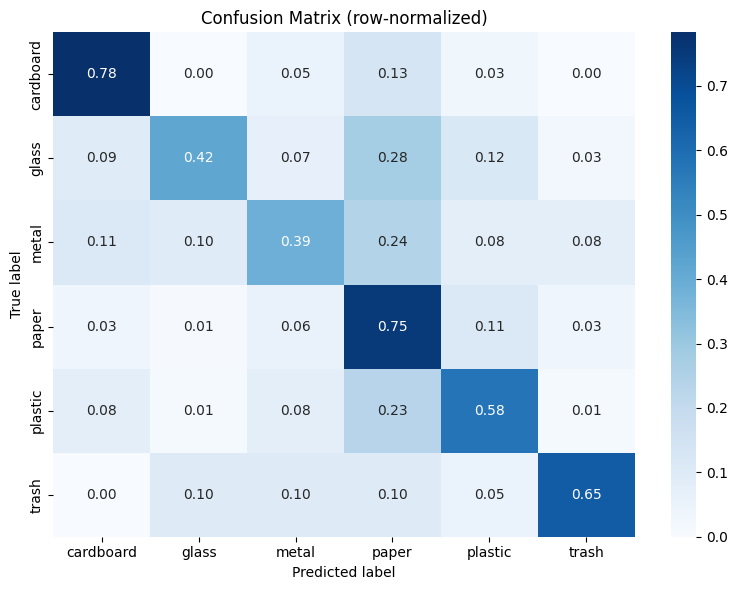

In [22]:
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (row-normalized)")
plt.tight_layout()
plt.show()


## Considerazioni

- La CNN sfrutta la struttura spaziale delle immagini, a differenza della baseline lineare.

- Le prestazioni risultano migliori rispetto alla logistic regression raggiungendo un test accuracy di circa il 59% (rispetto al 35% della logistic regression). In particolare:  
  - Le curve di val e train mostrano un apprendimento stabile con leggero overfitting indicando che la pipeline e lo split dei dati è avvenuto in modo corretto.  
  - La confusion matrix evidenzia un buon risultato con cardboard, paper, ma evidenzia anche confusione sistematica con materiali simili (plastic vs paper, glass vs metal) suggerendo ulteriore lavoro per migliorare le performance.

- Questo modello costituisce un punto di partenza per:
  - architetture più profonde
  - transfer learning (es. MobileNet, ResNet)
